# Privacy Attacks

<a target="_blank" href="https://colab.research.google.com/github/unica-mlsec/mlsec/blob/main/labs/08_privacy_attacks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we will implement two adversarial attacks targeting the **privacy** of ML models. In particular, we will experiment with **model inversion** and **model extraction** attacks. Both of them are executed at *test time*.

## Model inversion

Model inversion attacks aim to reconstruct **training samples** by iteratively querying the model. The simplest strategy to achieve this, given a pre-trained model with white-box access, consists of:
- choosing a target class label with respect to which to compute training samples;
- initialize a starting point (e.g., random noise);
- perform gradient-based optimization to maximize the target class score.

We first start by initializing and training a small convolutional neural network on the MNIST dataset.

In [76]:
import torch
import torch.nn as nn


class MNISTNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=10),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [77]:
net = MNISTNet()
device = "cuda"
net = net.to(device)

In [78]:
%%capture
import torchvision.datasets
from torch.utils.data import DataLoader


dataset_path = "data/datasets/"
training_dataset = torchvision.datasets.MNIST(
    transform=torchvision.transforms.ToTensor(),
    train=True,
    root=dataset_path,
    download=True,
)
training_data_loader = DataLoader(training_dataset, batch_size=64, shuffle=False)
test_dataset = torchvision.datasets.MNIST(
    transform=torchvision.transforms.ToTensor(),
    train=False,
    root=dataset_path,
    download=True,
)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We will leverage the SecML-Torch trainer to avoid writing the entire optimization code.

In [79]:
from torch.optim import Adam


optimizer = Adam(lr=1e-3, params=net.parameters())

In [80]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer

# Training MNIST model
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=5)
model = BasePytorchClassifier(model=net, trainer=trainer)
model.train(dataloader=training_data_loader)

MNISTNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

Let's also check the model performance...

In [81]:
from secmlt.metrics.classification import Accuracy

# Test MNIST model
accuracy = Accuracy()(model, test_data_loader)
print("test accuracy: ", accuracy)

test accuracy:  tensor(0.9833)


Now we can start coding our attack. We need an optimization loop that, given the model and a target class label, returns the reconstructed image.

We define a function to do so, adding other customizable arguments such as the loss and the number of iterations. For the loss, we accept any callable that takes as input the model output logits, the target class label, and the image that has been optimized.

In [82]:
def reconstruct_image(target_class, loss_function, n_iter):
    x = torch.rand((1, 1, 28, 28), device=device, requires_grad=True)
    optim_x = Adam(params=[x], lr=0.1)
    for step in range(n_iter):
        optim_x.zero_grad()
        logits = net(x)
        loss = loss_function(logits, target_class, x)
        loss.backward()
        optim_x.step()
        x.data.clamp_(0, 1)
    return x

We will start with a very simple loss function, i.e., the Cross-Entropy, computed with respect to the target class logit:
$$ CE = -\sum_{i=1}^C y_i \log \frac{e^{s_i}}{\sum_{j=1}^C e^{s_j}} = - \log \frac{e^{s_i}}{\sum_{j=1}^C e^{s_j}}$$

In [83]:
softmax = nn.Softmax(dim=1)

def loss_function(logits, target_class, input):
    prob = softmax(logits)[0, target_class]
    return -torch.log(prob + 1e-8)

We also define a util function to plot the reconstructed images.

In [84]:
import matplotlib.pyplot as plt


def plot_img(img):
    img = img.detach().cpu().squeeze()
    plt.figure(figsize=(3, 3))
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.show()

And finally we can run our attack!

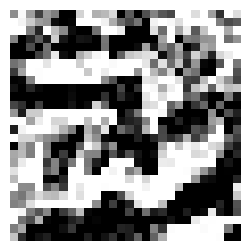

In [85]:
x = reconstruct_image(target_class=3, n_iter=500, loss_function=loss_function)
plot_img(x)

It's not so impressive... raw gradients are very noisy! To improve the result, we can add an L2 regularization term to the loss: this will stabilize gradients and make the reconstructed image *smoother*, by penalizing the image Euclidean norm. To balance the contribution of the two loss terms, we also multiply the regularization term by a small coefficient to control its influence.

In [86]:
def loss_function(logits, target_class, input):
    prob = softmax(logits)[0, target_class]
    return -torch.log(prob + 1e-8) + 1e-3 * (x**2).sum()

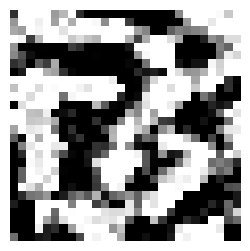

In [87]:
x = reconstruct_image(target_class=3, n_iter=500, loss_function=loss_function)
plot_img(x)

Still not enough... we can improve our loss by adding another term: the total variation loss. It returns the mean absolute differences between neighboring pixels horizontally and vertically, encouraging spatial smoothness while preserving edges.

In [88]:
def total_variation(x):
    # Differences between neighboring pixels horizontally (left vs right)
    horizontal_diff = x[:, :, :, :-1] - x[:, :, :, 1:]
    horizontal_avg_diff = torch.mean(torch.abs(horizontal_diff))

    # Differences between neighboring pixels vertically (top vs bottom)
    vertical_diff = x[:, :, :-1, :] - x[:, :, 1:, :]
    vertical_avg_diff = torch.mean(torch.abs(vertical_diff))

    # Total variation is the sum of horizontal and vertical differences
    return horizontal_avg_diff + vertical_avg_diff

In [89]:
def loss_function(logits, target_class, x):
    prob = softmax(logits)[0, target_class]
    return -torch.log(prob + 1e-8) + 1e-3 * (x**2).sum() + 1e-2 * total_variation(x)

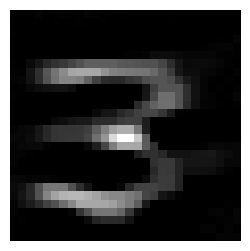

In [90]:
x = reconstruct_image(target_class=3, n_iter=500, loss_function=loss_function)
plot_img(x)

We can now try to obtain a reconstructed image for each class...

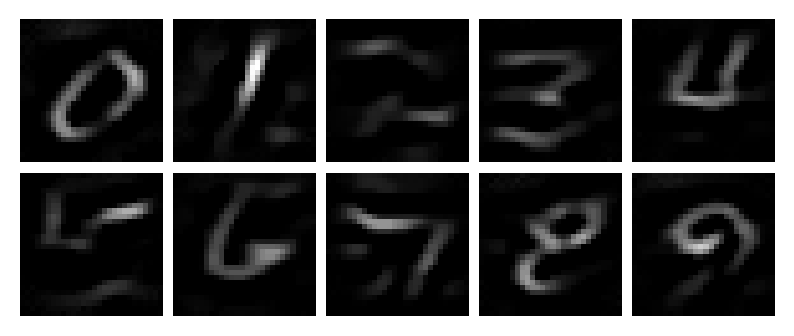

In [91]:
from torchvision.utils import make_grid


reconstructed = []
for i in range(10):
    reconstructed.append(reconstruct_image(target_class=i, n_iter=500, loss_function=loss_function))

reconstructed = torch.cat(reconstructed)

grid = make_grid(reconstructed[:], nrow=5, normalize=True, pad_value=1.0)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()

## Model extraction attacks

Model extraction attacks (also known as model stealing) aim to steal or replicate a target model given query access to it. In particular, their objective might be to infer its architecture, training hyperparameters or learned weights, or to simply reproduce their functionality (e.g., obtaining another model with the same performance).

We will try to train a new model by querying the previously trained convolutional neural network on MNIST, using a simpler architecture as surrogate.

In [92]:
class SurrogateMNISTNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 200)
        self.fc2 = torch.nn.Linear(200, 200)
        self.fc3 = torch.nn.Linear(200, 10)

    def forward(self, x):
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

We perform some queries to the victim model, using randomly generated data.

In [93]:
num_queries = 50000
random_queries = torch.rand((num_queries, 1, 28, 28)).to("cpu")

net.eval()
net = net.to("cpu")
with torch.no_grad():
    labels = net(random_queries).argmax(dim=1)

net = net.to(device)

We now create a new dataset that will be filled with the new generated data samples and their respective labels inferred from the victim model.

In [94]:
from torch.utils.data import Dataset


class QueryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], int(self.labels[idx])


query_dataset = QueryDataset(random_queries.cpu(), labels.cpu())
query_loader = DataLoader(query_dataset, batch_size=64, shuffle=True)

In [95]:
surrogate_net = SurrogateMNISTNet()
surrogate_net = surrogate_net.to(device)
optimizer = Adam(lr=1e-3, params=surrogate_net.parameters())
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=5)
surrogate_model = BasePytorchClassifier(model=surrogate_net, trainer=trainer)
surrogate_model.train(dataloader=query_loader)

SurrogateMNISTNet(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

In [96]:
accuracy = Accuracy()(surrogate_model, test_data_loader)
print("test accuracy: ", accuracy)

test accuracy:  tensor(0.2586)


The performance is not so impressive: using a random strategy to sample training points requires a huge amount of queries.

Let's try with a better approach, assuming the attacker has access to some of the (unlabeled) dataset images.

In [97]:
from torch.utils.data import Subset, ConcatDataset


subset_indices = list(range(1000))
mnist_subset = Subset(test_dataset, subset_indices)
combined_dataset = ConcatDataset([mnist_subset, query_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

In [98]:
surrogate_net = SurrogateMNISTNet()
surrogate_net = surrogate_net.to(device)
optimizer = Adam(lr=1e-3, params=surrogate_net.parameters())
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=3)
surrogate_model = BasePytorchClassifier(model=surrogate_net, trainer=trainer)
surrogate_model.train(dataloader=combined_loader)
accuracy = Accuracy()(surrogate_model, test_data_loader)
print("test accuracy: ", accuracy)

test accuracy:  tensor(0.8680)


If we have access to the output scores, we can directly optimize them by minimizing the soft Cross-Entropy loss, i.e., using the probability scores instead of the binary one-hot label encoding.

In [99]:
class QueryDataset(Dataset):
    def __init__(self, data, logits):
        self.data = data
        self.logits = logits
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.logits[idx]


imgs = []
logits = []
for x, _ in combined_loader:
    with torch.no_grad():
        imgs.append(x.cpu())
        logits.append(net(x.to(device)).cpu())

query_dataset = QueryDataset(torch.cat(imgs), torch.cat(logits))
query_loader = DataLoader(query_dataset, batch_size=64, shuffle=True)

In [100]:
surrogate_net = SurrogateMNISTNet()
surrogate_net = surrogate_net.to(device)
optimizer = Adam(lr=1e-4, params=surrogate_net.parameters())
trainer = BasePyTorchTrainer(optimizer=optimizer, epochs=10)
surrogate_model = BasePytorchClassifier(model=surrogate_net, trainer=trainer)
surrogate_model.train(dataloader=query_loader)
accuracy = Accuracy()(surrogate_model, test_data_loader)
print("test accuracy: ", accuracy)

test accuracy:  tensor(0.8680)
